In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import io
import requests

### Data import and cleaning

For this project I am using publicly avalaible data on weekly & hourly earnings from the bureau of labor statistics, more information can be found here: 
http://www.bls.gov/data/.  The data is available on:
http://download.bls.gov/pub/time.series/le/. 

The first dataset I will use is le.series and contains series id's and all their attributes. 
The first column contains the series id, the following columns contain all the attribute codes, f.i. sexs_code = 0 refers to the time series that contain data on both sexes, sexs_code =1 is only males and sexs_code 2 is only females. Similarly indy_code=0 refers to all industries but all other codes refer to data on every individual industry. The explanation of these codes can be found in all the individual datasets such as le.sexs, le.indy, le.ages etc. 

I've gone through them all and filtered out only the series id's that will be usefull for this analysis.

In [2]:
#Import data for what series I need, filter out relevant series only
url="http://download.bls.gov/pub/time.series/le/le.series"
s=requests.get(url).content

#set to correct data types and filter out all the relevant series
series_id=pd.read_csv(io.StringIO(s.decode('utf-8')),sep="\t")
series_id['seasonal']=series_id['seasonal'].astype('str')
series_id['seasonal']=series_id['seasonal'].str.strip()
series_id['series_id']=series_id['series_id'].astype('category')
series_id['series_id']=series_id['series_id'].str.strip()

#filter on relevant series id's only
series_id_subset=series_id[(series_id.lfst_code==25)&
                    (series_id.fips_code==0)&
                    (series_id.tdata_code==0)&
                    (series_id.pcts_code==0)&
                    (series_id.earn_code==1)&
                    (series_id.class_code==16)&
                    (series_id.unin_code==0)&
                    (series_id.indy_code==0)&
                    (series_id.occupation_code==0)&
                    (series_id.education_code==0)&
                    (series_id.ages_code<>0)&(series_id.ages_code<>10)&(series_id.ages_code<>28)&(series_id.ages_code<>33)&
                    (series_id.race_code==0)&
                    (series_id.orig_code==0)&
                    (series_id.born_code==0)&
                    (series_id.sexs_code<>0)&
                    (series_id.seasonal=='U')]
series_id_subset=series_id_subset.loc[:,['series_id','sexs_code','ages_code','earn_code']]

The next step is to get the time series dataset le.data.1.AllData and filter out all timeseries with the relevant series id's only. I'm filtering out all data for period Q5, those rows contain the data for the whole year. I'm also merging with le.ages and le.sexs to get the names for age and sex category instead of just the codes. 

In [3]:
#import time series dataset and filter out relevant series only
url="http://download.bls.gov/pub/time.series/le/le.data.1.AllData"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')),sep="\t")
df['series_id']=df['series_id'].astype('category')
df['series_id']=df['series_id'].str.strip()
df=df[df['series_id'].isin(series_id_subset['series_id'])]
df=df[(df.year>1990)&(df.period=='Q05')]
df['value']=pd.to_numeric(df['value'],errors='coerce')

#merge with series, ages and sexs
df=pd.merge(df,series_id_subset, on='series_id')

In [4]:
#merge with ages
url="http://download.bls.gov/pub/time.series/le/le.ages"
s=requests.get(url).content
ages=pd.read_csv(io.StringIO(s.decode('utf-8')),sep="\t",index_col=False)
df=pd.merge(df,ages, on='ages_code')

#merge with sexs
url="http://download.bls.gov/pub/time.series/le/le.sexs"
s=requests.get(url).content
sexs=pd.read_csv(io.StringIO(s.decode('utf-8')),sep="\t",index_col=False)
df=pd.merge(df,sexs, on='sexs_code')

#remove irrelevant collumns, rename and reshape
df=df.loc[:,['year','sexs_text','ages_text','value']]
df.columns=['year','gender','age group','value']
df=df.groupby(['year','age group','gender']).sum()
df=df['value'].unstack('gender')
df['percentage']=1-df['Women']/df['Men']
#df.head(5)

## Data story
### Why my generation doesn't care about the pay gap (yet)

It is often quoted that women make .79 cents for every 1 dollar a man makes. This is a huge difference yet it is not something me and my friends talk about. So why does my generation not care about this more? And more importanly, why isn't this difference more apparent to us? 

I strongly doubt that my male co-workers and friends on average make over 20% more than my female co-workers and friends and somehow none of us even noticed. This discrepancy between what is said in the media and what is apparent in daily life made me wonder if maybe the pay gap for our age category is different than the overall pay gap. 

Based on data from the Bureau of Labor Statistics I compared weekly wages for full-time employed people per age group. And as expected the pay gap is only 10% for woman in their 20s and early 30s. I'm not compansating for industry yet but if I would the difference might completly disappear. However things go downhill from there, for women over 55 the pay gap has increased up to 25%. 

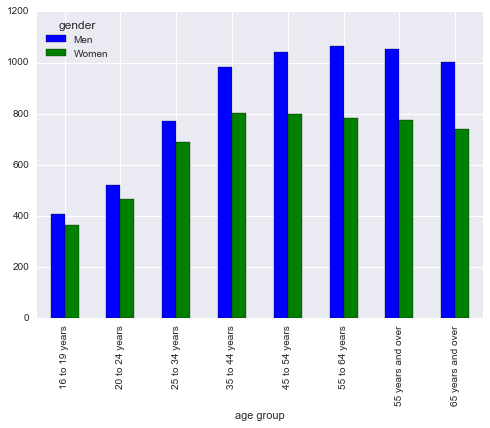

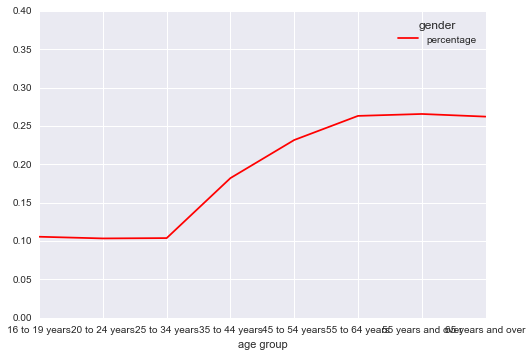

In [5]:
#plot1
plot_data=df.stack().unstack('year')[2015].unstack('gender')
plot_data.loc[:,['Men','Women']].plot(kind='bar')

#plot2 (put next to other plot and rotate labels)
plot_data.loc[:,['percentage']].plot(ylim=(0,0.4),color='red',)

This could be progress, maybe women my age are reaping the benefits from earlier generations of women who fought for equal rights. So I decided to see how this developed over time. As it turns out there is progress (though slow) but not enough to explain the increase of the pay gap per age completly. Someone who was 20 in 1990 was making about 10% less than her male counterparts, in 2000 she would have be 30 and making 17% less than her male counterparts and in 2015 she would be 45 and making 23% less than her male counterparts. It's not a great outlook for people my age. We might be doing fine now but we'd better be nice to our husbands because who knows where we'll be 20 years down the line. 

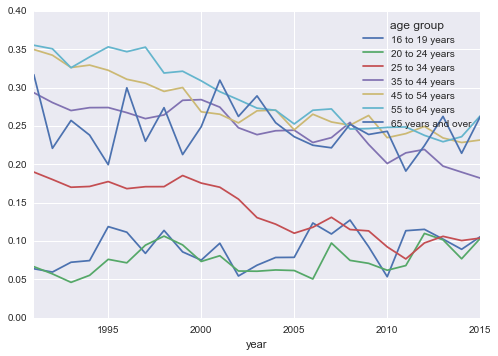

In [6]:
#plot over time (still to prettify)
plot_data=df.loc[:,['percentage']].unstack('age group')['percentage'].dropna(axis=1)
plot_data.plot(kind='line')

### Why does this matter?

Without further research this doesn't explain why the pay gap persists. However it does give us more insight on where  to look. It's unlikely that woman are perfectly capable of negotiating for themselves in their 20's yet somehow forget about that in their 40's. They also don't all of a sudden lose their intelligence, talent, educational background or make major career switches. However it does fall in line with many pleas from young mothers for better parental leave (for both parents) and a persistent lack of woman in higher management positions. Maybe in their 30s women get a baby and men get a promotion. 

This kind of nuance also helps create the right kind of discussions around gender eqaulity issues. Throwing a number like .79 cents to the dollar around without the right context makes the message far too easy to rebuke by opposers. And it makes it hard to relate with for the right people in order to get traction. Why should I care about a number that obviously does not apply to me at this point in my life? However being confronted with the fact that my prospects for the future are not as good as the prospects of my male peers resonates with me in a much stronger way. 

There are still plenty of issues, I have no doubt about that. But I strongly believe we have to make sure that when we talk about it we do so with the right data and context around it. 